# Partie 3: application à la classification de fonds marins


Dans la suite, vous êtes chargé :
- d'appliquer la démarche décrite dans la partie 2 aux données des images sonar de fonds marins rencontrés précédemment. 
- Analyser proprement les performances
- Modifier l'architecture de réseau pour améliorer les performances

Si vous ne savez pas commencer, le script ci-dessous pourra certainement vous aider à démarrer.


In [61]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import tools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

In [76]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    DATASET_PATH = 'gdrive/My Drive/Colab Notebooks/ex06_supervised_seabedClassification/dataset/imgs/'
    LABEL_PATH = 'gdrive/My Drive/Colab Notebooks/ex06_supervised_seabedClassification/dataset/labels/labels.csv'
else:
    IN_COLAB = False
    DATASET_PATH = r'./dataset/imgs/'
    LABEL_PATH = r'./dataset/labels/labels.csv'

# Charger le fichier CSV
dataset_df = pd.read_csv(LABEL_PATH)
dataset_df['image_path'] = dataset_df.apply(lambda row: (DATASET_PATH + row["id"]), axis=1)


# Charger les images et les labels
images = np.array([plt.imread(img) for img in dataset_df['image_path'].values.tolist()])
label_names = dataset_df['seafloor'].to_numpy()

# transformer les labels en indices
label_names = dataset_df['seafloor']

label_names_unique = label_names.unique()
le = preprocessing.LabelEncoder()
le.fit(label_names_unique)
label_indices = le.transform(label_names)


# rajout d'une dimension chanel pour coller au formalisme de tensorflow
images = images[...,np.newaxis]
img_shape = images.shape[1:3]
num_channels =  images.shape[3]
num_classes= np.amax(label_indices) + 1

print('images shape: {}'.format(img_shape))
print('color channels: {}'.format(num_channels))
print('classes Count: {}'.format(num_classes))


# Création du dataset en objet tf.data.Dataset
tf_dataset = tf.data.Dataset.from_tensor_slices((images, label_indices))

    

images shape: (200, 200)
color channels: 1
classes Count: 6


## Prétraitement des données

In [77]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

tf_dataset = tf_dataset.map(normalize_img)


### Melange des données et création d'un batch d'apprentissage

In [78]:
tf_dataset = tf_dataset.shuffle(tf_dataset.cardinality())

In [79]:
batch_size=100
tf_dataset = tf_dataset.batch(batch_size, drop_remainder=True)

In [80]:
elem = next(iter(tf_dataset))
image = elem[0].numpy()
label = elem[1].numpy()

print(image.shape)
print(label.shape)

(100, 200, 200, 1)
(100,)


In [109]:
def plot_images(images, target_true, target_pred=None):
    assert images.shape[0] == target_true.shape[0] == 9
    #assert len(images) == len(target_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i, ..., 0], cmap='binary')

        # Show true and predicted classes.
        if target_pred is None:
            xlabel = "True: {0}".format(target_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(target_true[i], target_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


In [111]:
plot_images(image[:9], label[:9])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## Creation d'un Réseau de Neuronnes

### Création d'un model

In [83]:

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=img_shape),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

### Fonction de support

In [84]:
# performance du modèle
def eval_loop():
    # evaluating the model
    cor_pred = []
    accuracy_tot = []
    for i_batch, (img, target_label) in enumerate(tf_dataset):
        # mise en forme
        # img = tf.reshape(img, [batch_size, input_img_size])
        # target_labels = label  # tf.one_hot(label, num_classes)

        # logits = tf.matmul(img, weights) + biases
        target_pred = model(img, training=False)

        # Now logits is a matrix with num_images rows and num_classes columns, where the element of the $i$'th row and $j$'th column is an estimate of how likely the $i$'th input image is to be of the $j$'th class.
        #
        # However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each row of the logits matrix sums to one, and each element is limited between zero and one. This is calculated using the so-called softmax function and the result is stored in y_pred.
        # target_pred_ohe = tf.nn.softmax(logits)

        # The predicted class can be calculated from the y_pred matrix by taking the index of the largest element in each row.
        target_pred = tf.argmax(target_pred, axis=1)

        # performance measures
        correct_prediction = tf.equal(tf.cast(target_pred, dtype=tf.int64), tf.cast(target_label,dtype=tf.int64))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        cor_pred.append(correct_prediction)
        accuracy_tot.append(accuracy.numpy())

    print('model accuracy: {}'.format(np.mean(accuracy_tot)))
    # return accuracy_tot

#
eval_loop()

model accuracy: 0.16333332657814026


In [85]:
def plot_weights(weights, img_shape):

        # Get the lowest and highest values for the weights.
        # This is used to correct the colour intensity across
        # the images so they can be compared with each other.
        w_min = np.min(weights)
        w_max = np.max(weights)

        # Create figure with 3x4 sub-plots,
        # where the last 2 sub-plots are unused.
        fig, axes = plt.subplots(3, 4)
        fig.subplots_adjust(hspace=0.3, wspace=0.3)

        for i, ax in enumerate(axes.flat):
            # Only use the weights for the first 10 sub-plots.
            if i < num_classes:
                # Get the weights for the i'th digit and reshape it.
                # Note that w.shape == (img_size_flat, 10)
                image = weights[:, i].reshape(img_shape)

                # Set the label for the sub-plot.
                ax.set_xlabel("Weights: {0}".format(i))

                # Plot the image.
                ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

            # Remove ticks from each sub-plot.
            ax.set_xticks([])
            ax.set_yticks([])

        # Ensure the plot is shown correctly with multiple plots
        # in a single Notebook cell.
        plt.show()


2
[[ 0.00775288  0.00191449  0.00172545 -0.00831376 -0.0053738  -0.00122248]
 [ 0.00110551  0.00392664  0.00708532  0.00419658  0.01158986  0.00288192]
 [-0.00922009 -0.01027409 -0.00939425  0.00977555 -0.00115367  0.00836207]
 ...
 [ 0.01130704 -0.00625014  0.00171561  0.00540144  0.00198854 -0.00285994]
 [ 0.00230588  0.00352088 -0.00483479  0.0093054  -0.00606139  0.00520417]
 [ 0.00060688  0.01044859 -0.00890853 -0.0005959   0.00657629  0.00829127]]
(200, 200)


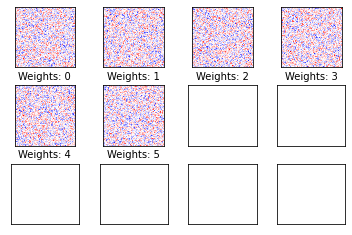

In [86]:
''' START CODE HERE '''
# Get the values for the weights from the TensorFlow variable.
weights = model.get_weights()
print(len(weights))
weights = weights[0]
print(weights)

''' END CODE HERE '''

# visualisation des poids
print(img_shape)
plot_weights(weights, img_shape)

In [87]:
loss_fcn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss(model, x, y, training):
    # training=training is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    y_ = model(x, training=training)

    return loss_fcn(y_true=y, y_pred=y_)

l = loss(model, image, label, training=False)
print("Loss test: {}".format(l))


 # Utilisez le contexte tf.GradientTape pour calculer les gradients utilisés pour optimiser votre modèle:

def grad(model, inputs, targets):
    
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training=True)
    
    return loss_value, tape.gradient(loss_value, model.trainable_variables)



Loss test: 1.7917625904083252


In [88]:
optimizer_fcn = tf.keras.optimizers.SGD(learning_rate=1.0)

def optimize(features, target_labels):

    # Compute the loss and the gradient
    loss_value, grads = grad(model, features, target_labels)

    # mise à jour des paramètres
    optimizer_fcn.apply_gradients(zip(grads, model.trainable_variables))

    # return gradients


Step: 1,         Loss: 1.7915610074996948
model accuracy: 0.16333334147930145


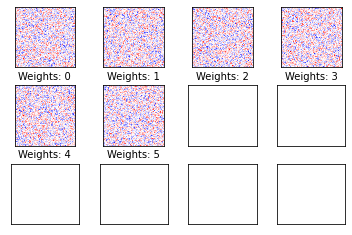

' END CODE HERE '

In [90]:
''' START CODE HERE '''
# Get a batch of (images, labels) from the training set
(img_batch, label_batch) = next(iter(tf_dataset))

# Call the optimize function
optimize(img_batch, label_batch)

# Evaluate the loss for each step
print("Step: {},         Loss: {}".format(optimizer_fcn.iterations.numpy(), loss(model, img_batch, label_batch, training=True).numpy()))

# Evaluate the accuracy
eval_loop()

# Visualize the weights of the model
weights = model.get_weights()
weights = weights[0]
plot_weights(weights, img_shape[0:2])
''' END CODE HERE '''


In [93]:
def train_loop(num_epochs):
    for epoch in range(0, num_epochs, 1):

        # Get a batch of training examples.
        # img_batch now holds a batch of images and
        # label_batch are the true labels for those images.
        (img_batch, label_batch) = next(iter(tf_dataset))

        # optimize
        optimize(img_batch, label_batch)

        print("Step: {},         Loss: {}".format(optimizer_fcn.iterations.numpy(), loss(model, img_batch, label_batch, training=True).numpy()))



Step: 2,         Loss: 1.791285753250122
model accuracy: 0.17999999225139618


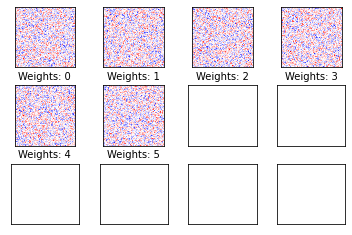

' END CODE HERE '

In [94]:
num_epochs = 1


''' START CODE HERE '''
train_loop(num_epochs)

# Evaluate the accuracy
eval_loop()

# Visualize the weights of the model
weights = model.get_weights()
weights = weights[0]
plot_weights(weights, img_shape[0:2])
''' END CODE HERE '''

Step: 3,         Loss: 1.7918007373809814
Step: 4,         Loss: 1.7917453050613403
Step: 5,         Loss: 1.791770577430725
Step: 6,         Loss: 1.7917388677597046
Step: 7,         Loss: 1.7910794019699097
Step: 8,         Loss: 1.7913932800292969
Step: 9,         Loss: 1.7913312911987305
Step: 10,         Loss: 1.7912304401397705
Step: 11,         Loss: 1.7918462753295898
Step: 12,         Loss: 1.7919447422027588
model accuracy: 0.1666666716337204


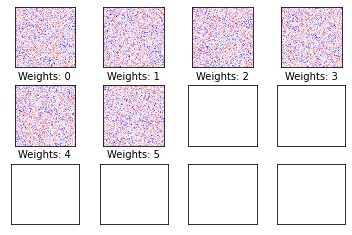

In [95]:
num_epochs = 10


''' START CODE HERE '''
train_loop(num_epochs)

# Evaluate the accuracy
eval_loop()

# Visualize the weights of the model
weights = model.get_weights()
weights = weights[0]
plot_weights(weights, img_shape[0:2])

In [96]:
model.compile(
              loss=loss_fcn, 
              optimizer=optimizer_fcn, 
              metrics=[tf.keras.metrics.sparse_categorical_accuracy]
             )


In [97]:
num_epochs = 100
history = model.fit(tf_dataset, epochs=num_epochs, validation_data=tf_dataset)

Epoch 1/100
3/3 [==============================] - 0s 76ms/step - loss: 1.7918 - sparse_categorical_accuracy: 0.1767 - val_loss: 1.7919 - val_sparse_categorical_accuracy: 0.1600
Epoch 2/100
3/3 [==============================] - 0s 47ms/step - loss: 1.7919 - sparse_categorical_accuracy: 0.1633 - val_loss: 1.7919 - val_sparse_categorical_accuracy: 0.1567
Epoch 3/100
3/3 [==============================] - 0s 48ms/step - loss: 1.7918 - sparse_categorical_accuracy: 0.1667 - val_loss: 1.7918 - val_sparse_categorical_accuracy: 0.1633
Epoch 4/100
3/3 [==============================] - 0s 49ms/step - loss: 1.7918 - sparse_categorical_accuracy: 0.1633 - val_loss: 1.7919 - val_sparse_categorical_accuracy: 0.1533
Epoch 5/100
3/3 [==============================] - 0s 48ms/step - loss: 1.7918 - sparse_categorical_accuracy: 0.1700 - val_loss: 1.7918 - val_sparse_categorical_accuracy: 0.1700
Epoch 6/100
3/3 [==============================] - 0s 49ms/step - loss: 1.7917 - sparse_categorical_accuracy: 

In [98]:
# Saving and Restoring the model
# architecture and weights
model.save("my_keras_model.h5")
model = keras.models.load_model("my_keras_model.h5")

# weights only
model.save_weights("my_keras_weights.ckpt")
model.load_weights("my_keras_weights.ckpt")

In [100]:
target_pred = model.predict(tf_dataset)
target_label_pred = tf.argmax(target_pred, axis=1).numpy()
print(target_label_pred.shape)

(300,)


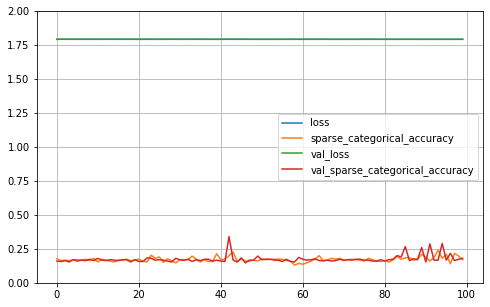

3/3 [==============================] - 0s 4ms/step - loss: 1.7915 - sparse_categorical_accuracy: 0.2067
{'loss': 1.7915116548538208, 'sparse_categorical_accuracy': 0.20666666328907013}
model accuracy: 0.18666665256023407


In [102]:
# learning curves
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2)  # set the vertical range to [0-1]
plt.show()

# métriques de performance:


result = model.evaluate(tf_dataset)
print(dict(zip(model.metrics_names, result)))

eval_loop()

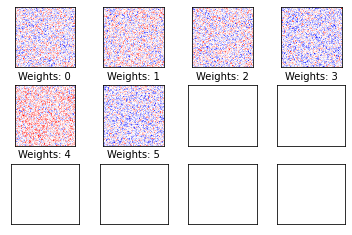

In [103]:
# Visualize the weights of the model
weights = model.get_weights()
weights = weights[0]
plot_weights(weights, img_shape[0:2])


In [104]:
target_pred = model.predict(tf_dataset)
target_label_pred = tf.argmax(target_pred, axis=1).numpy()

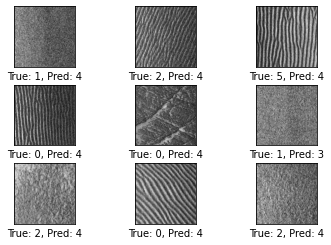

In [107]:
tmp = [target_label_actual for (img, target_label_actual) in tf_dataset]

target_label_actual = []
[ target_label_actual.extend(el.numpy()) for el in tmp]
target_label_actual = np.array(target_label_actual)

tmp = [img for (img, target_label_actual) in tf_dataset]
imgs = []
[ imgs.extend(el.numpy()) for el in tmp]
imgs = np.array(imgs)

uncorrect = np.where(target_label_pred != target_label_actual)[0]
uncorrect = uncorrect[0:9] # juste pour le display
plot_images(imgs[uncorrect,:,:,:], target_label_actual[uncorrect], target_pred=target_label_pred[uncorrect])
